In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def show(image):
    if image.shape[-1] == 1:
        image = image.reshape(image.shape[0:-1])
    plt.imshow(image)
    plt.show()

def pooling(mat,ksize,method='mean',pad=False):
    m, n = mat.shape[:2]
    ky,kx=ksize
    _ceil=lambda x,y: int(np.ceil(x/float(y)))
    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=np.full(size,np.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]
    new_shape=(ny,ky,nx,kx)+mat.shape[2:]
    if method=='max':
        result=np.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
    else:
        result=np.nanmean(mat_pad.reshape(new_shape),axis=(1,3))
    return result

def resized(matrix, factor = 2):
    h, w, *c = matrix.shape
    matrix = cv2.resize(matrix.astype('float32'), dsize=(w * factor, h * factor),
                        interpolation=cv2.INTER_NEAREST)
    return matrix


class mask:
    def __init__(self, image, kernel_size = 2, center = [0.5, 0.5], side = 0.8):
        img_height, img_width = image.shape[:2]
        radius = side / 2
        y_min, y_max = center[0] - radius, center[0] + radius
        x_min, x_max = center[1] - radius, center[1] + radius
        y_min, y_max, x_min, x_max = (max(0, y_min), min(1, y_max),
                                      max(0, x_min), min(1, x_max))
        kernel_round = lambda x, ks: int((x // ks) * ks)
        y_min = kernel_round(img_height * y_min, kernel_size)
        y_max = kernel_round(img_height * y_max, kernel_size)
        x_min = kernel_round(img_width  * x_min, kernel_size)
        x_max = kernel_round(img_width  * x_max, kernel_size)
        self.sides = (y_min, y_max, x_min, x_max)
        self.image = pooling(image[y_min:y_max,x_min:x_max],
                             ksize = (kernel_size, kernel_size))
        self.kernel_size = kernel_size
        
    def flatten(self):
        return self.image.flatten()

    def representation(self):
        return resized(self.image, factor=self.kernel_size)

    def __repr__(self):
        return "mask: {}, kernel size: {}, sides: {}".format(self.image.shape,
                                                             self.kernel_size,
                                                             self.sides)


class adaPool:
    def __init__(self, image, centers = [[0.5, 0.5]], max_kernel = 2, focus = 0.4):
        masks = []
        kernel_size = max_kernel
        side = 1
        while kernel_size != 0:
            for center in centers:
                masks.append(mask(image, kernel_size, center, side))
            kernel_size //= 2
            side *= focus
        
        self.masks = masks
        self.centers = centers
        self.image = image
        self.max_kernel = max_kernel
        self.focus = focus
    
    def flatten(self):
        res = np.array([])
        for mask in self.masks:
            res = np.append(res, mask.flatten())
        return res

    def representation(self):
        plot = np.zeros(self.image.shape)
        for mask in self.masks:
            y_min, y_max, x_min, x_max = mask.sides
            plot[y_min:y_max, x_min:x_max] = mask.representation()
        return plot



In [ ]:
'''
img = cv2.imread("/content/чайка.jpg")
img = np.array(img, dtype=np.float32)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img /= 255
img = adaPool(img, centers = [[0.4, 0.55]], max_kernel = 32, focus = 0.5)
show(img.representation())
'''

'\nimg = cv2.imread("/content/чайка.jpg")\nimg = np.array(img, dtype=np.float32)\nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\nimg /= 255\nimg = adaPool(img, centers = [[0.4, 0.55]], max_kernel = 32, focus = 0.5)\nshow(img.representation())\n'

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train, y_train = x_train[:60000], y_train[:60000]

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

default_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(50,  activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

default_model.summary()

x_train shape: (50000, 32, 32, 3, 1)
50000 train samples
10000 test samples
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                153650    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                510       
Total params: 154,160
Trainable params: 154,160
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train_pool = []
x_test_pool = []
max_kernel_size = 4
focus = 0.3
for i, x in enumerate(x_train):
    x = adaPool(x)
    x_train_pool.append(x.flatten())
    if i % 5000== 0:
        print("{} / {}".format(i, x_train.shape[0]))

for i, x in enumerate(x_test):
    x = adaPool(x)
    x_test_pool.append(x.flatten())
    if i % 5000== 0:
        print("{} / {}".format(i, x_test.shape[0]))

x_train_pool = np.array(x_train_pool)
x_test_pool = np.array(x_test_pool)
print(x_train_pool.shape)
print(x_test_pool.shape)

0 / 50000
5000 / 50000
10000 / 50000
15000 / 50000
20000 / 50000
25000 / 50000
30000 / 50000
35000 / 50000
40000 / 50000
45000 / 50000
0 / 10000
5000 / 10000
(50000, 1275)
(10000, 1275)


In [ ]:
pooled_model = keras.Sequential(
    [
        keras.Input(shape=x_train_pool[0].shape),
        layers.Flatten(),
        layers.Dense(50,  activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

pooled_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 1275)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                63800     
_________________________________________________________________
dense_25 (Dense)             (None, 10)                510       
Total params: 64,310
Trainable params: 64,310
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 32
epochs = 15

default_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
pooled_model.compile( loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

default_history = default_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.4)
pooled_history  = pooled_model.fit( x_train_pool, y_train, 
                                   batch_size=batch_size, epochs=epochs, validation_split=0.4)

score = default_model.evaluate(x_test, y_test, verbose=0)
pooled_score = pooled_model.evaluate(x_test_pool, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

print("Test loss pooled:", pooled_score[0])
print("Test accuracy pooled:", pooled_score[1])

Epoch 1/15
938/938 [==============================] - 4s 4ms/step - loss: 1.9619 - accuracy: 0.2921 - val_loss: 1.8898 - val_accuracy: 0.3189
Epoch 2/15
938/938 [==============================] - 3s 3ms/step - loss: 1.8311 - accuracy: 0.3516 - val_loss: 1.8833 - val_accuracy: 0.3379
Epoch 3/15
938/938 [==============================] - 3s 3ms/step - loss: 1.7863 - accuracy: 0.3644 - val_loss: 1.7933 - val_accuracy: 0.3673
Epoch 4/15
938/938 [==============================] - 3s 3ms/step - loss: 1.7614 - accuracy: 0.3757 - val_loss: 1.7571 - val_accuracy: 0.3871
Epoch 5/15
938/938 [==============================] - 3s 3ms/step - loss: 1.7446 - accuracy: 0.3821 - val_loss: 1.7749 - val_accuracy: 0.3720
Epoch 6/15
938/938 [==============================] - 3s 3ms/step - loss: 1.7351 - accuracy: 0.3852 - val_loss: 1.7579 - val_accuracy: 0.3722
Epoch 7/15
938/938 [==============================] - 3s 4ms/step - loss: 1.7188 - accuracy: 0.3883 - val_loss: 1.7958 - val_accuracy: 0.3595
Epoch 

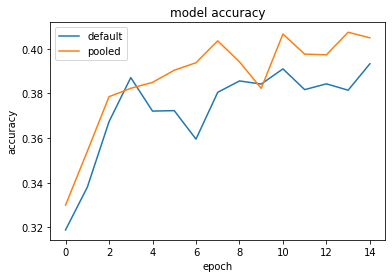

In [ ]:
acc = default_history.history['val_accuracy']
p_acc   = pooled_history.history['val_accuracy']
plt.plot(acc)
plt.plot(p_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['default', 'pooled'], loc='upper left')
plt.show()